In [6]:
# 데이터 처리에 필요한 라이브러리
import pandas as pd
import numpy as np

# 시각화에 필요한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# 경고문 무시하는 라이브러리
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split # train 데이터 셋과 test 데이터 셋 분리하는 라이브러리
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier을 진행하는 라이브러리
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # 정확도 및 혼동 행렬을 위한 라이브러리

In [7]:
# train 파일 할당
train_df = pd.read_csv('train.csv', encoding='utf-8')

# test 파일 할당
test_df = pd.read_csv('test.csv', encoding='UTF8')

In [8]:
# URL에서 [.]을 .으로 복구
train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

In [9]:
# URL 길이
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x)) -2
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x)) -2

# 특수 문자('-', '_', '/') 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))

In [10]:
## 각 특수 문자 개수 (‘?, ‘-‘=,‘.’,‘%’,‘+',‘//’)
train_df['special_char_count_plus'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in '?-=%+//'))
test_df['special_char_count_plus'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in '?-=%+//'))

In [11]:
## 특수 문자 비율
import string

def special_char_ratio(text):
    total_chars = len(text)
    if total_chars == 0:
        return 0  # 빈 문자열이면 비율 0 반환

    special_chars = sum(1 for char in text if char not in string.ascii_letters + string.digits + string.whitespace)

    return special_chars / total_chars

train_df['special_char_ratio'] = train_df["URL"].apply(special_char_ratio)
test_df['special_char_ratio'] = test_df["URL"].apply(special_char_ratio)

In [12]:
# 'www.' or '.com' 포함 여부
# 새로운 열 www.com
# True : 있음 / False : 없음

# 특정 단어 리스트
keywords = ['www.', '.com']

# 특정 단어가 포함되면 False, 없으면 True 할당
train_df['www.com'] = train_df['URL'].apply(
    lambda x: int(True) if any(word in x for word in keywords) else int(False))
test_df['www.com'] = test_df['URL'].apply(
    lambda x: int(True) if any(word in x for word in keywords) else int(False))

In [13]:
# url 숫자 개수
train_df['num_count'] = train_df['URL'].apply(lambda x: sum(c.isdigit() for c in str(x)))
test_df['num_count'] = test_df['URL'].apply(lambda x: sum(c.isdigit() for c in str(x)))

# url 문자 개수
train_df['str_count'] = train_df['URL'].apply(lambda x: sum(c.isalpha() for c in str(x)))
test_df['str_count'] = test_df['URL'].apply(lambda x: sum(c.isalpha() for c in str(x)))

In [14]:
# long_url_phishing
# 피싱 URL 여부 판단 함수
def is_long_url_phishing(url, threshold=55):
    return int(len(url) >= threshold)  # URL 길이가 특정 임계값(threshold) 이상이면 True

train_df['long_url_phishing'] = train_df['URL'].apply(is_long_url_phishing)
test_df['long_url_phishing'] = test_df['URL'].apply(is_long_url_phishing)

In [16]:
# hyphen_in_url
# URL에 하이픈 포함 여부 확인 함수
def has_hyphen_in_url(url):
    return int('-' in url)  # URL에 '-'(하이픈)이 포함되어 있으면 True, 아니면 False

train_df['hyphen_in_url'] = train_df['URL'].apply(has_hyphen_in_url)
test_df['hyphen_in_url'] = test_df['URL'].apply(has_hyphen_in_url)

In [17]:
## url 경로 길이
from urllib.parse import urlparse, parse_qs #라이브러리 할당

# URL 경로 길이 계산 함수
def get_path_length(url):
    path = urlparse(url).path  # URL에서 경로 추출
    return len(path)  # 경로 문자열의 길이 반환

train_df['path_length'] = train_df['URL'].apply(get_path_length)
test_df['path_length'] = test_df['URL'].apply(get_path_length)

In [18]:
## url 경로 깊이
def get_path_depth(url):
    path = urlparse(url).path  # URL에서 경로 추출
    path_segments = [segment for segment in path.split('/') if segment]  # 빈 값 제외
    return len(path_segments)  # 경로 깊이 반환

train_df['path_depth'] = train_df['URL'].apply(get_path_depth)
test_df['path_depth'] = test_df['URL'].apply(get_path_depth)

In [19]:
## 파일 확장자 길이

# 파일 확장자 길이 계산 함수
def get_extension_length(url):
    path = urlparse(url).path  # URL에서 경로 추출
    if '.' in path:
        extension = path.split('.')[-1]  # 마지막 점 이후 문자열 추출
        return len(extension)
    return 0  # 확장자가 없을 경우 0 반환

train_df['extension_length'] = train_df['URL'].apply(get_extension_length)
test_df['extension_length'] = test_df['URL'].apply(get_extension_length)

In [20]:
## 파일 확장자 특수 문자 개수
import re # 라이브러리 할당

# 파일 확장자 내 특수문자 개수 계산 함수
def count_special_chars_in_extension(url):
    path = urlparse(url).path  # URL에서 경로 추출
    if '.' in path:
        extension = path.split('.')[-1]  # 마지막 점 이후 문자열을 확장자로 추출
        special_chars = re.findall(r'[^a-zA-Z0-9]', extension)  # 특수문자 찾기
        return len(special_chars)
    return 0  # 확장자가 없으면 0 반환

train_df['extension_special_char_count'] = train_df['URL'].apply(count_special_chars_in_extension)
test_df['extension_special_char_count'] = test_df['URL'].apply(count_special_chars_in_extension)

In [21]:
## 파일 확장자 숫자 포함 여부
# 확장자에 숫자가 포함되어 있는지 확인하는 함수
def has_number_in_extension(url):
    path = urlparse(url).path  # URL에서 경로 추출
    if '.' in path:
        extension = path.split('.')[-1]  # 마지막 점 이후 문자열을 확장자로 추출
        return int(bool(re.search(r'\d', extension)))  # 숫자가 포함되어 있으면 True, 없으면 False
    return int(False)  # 확장자가 없으면 False 반환

train_df['extension_has_number_in_ext'] = train_df['URL'].apply(has_number_in_extension)
test_df['extension_has_number_in_ext'] = test_df['URL'].apply(has_number_in_extension)

In [22]:
# 쿼리 파라미터
def count_query_parameters(url):
    parsed_url = urlparse(url)  # URL을 파싱
    query_params = parse_qs(parsed_url.query)  # 쿼리 문자열을 딕셔너리로 변환
    return len(query_params)  # 파라미터 개수 반환

# 'URL' 열의 각 URL에 대해 파라미터 개수 계산하여 새로운 열에 저장
train_df['query_param_count'] = train_df['URL'].apply(count_query_parameters)
test_df['query_param_count'] = test_df['URL'].apply(count_query_parameters)

In [23]:
import re

def count_consecutive_words(url):
    # URL을 구분 기호로 분리
    parts = re.split(r'[/\.\-_]', url)

    # 연속된 단어 수를 저장할 딕셔너리
    word_count = {}

    # 이전 부분 문자열과 현재 부분 문자열
    prev_part = None
    count = 1

    # 분리된 부분 문자열들을 순회
    for part in parts:
        if part == prev_part:
            # 이전 부분 문자열과 동일하면 count 증가
            count += 1
        else:
            # 이전 부분 문자열과 다르면
            if prev_part and count > 1:
                # 이전 부분 문자열이 있고 count가 1보다 크면 딕셔너리에 추가
                word_count[prev_part] = count

            # 현재 부분 문자열을 prev_part로 설정하고 count를 1로 초기화
            prev_part = part
            count = 1

    # 마지막 부분 문자열 처리
    if prev_part and count > 1:
        word_count[prev_part] = count

    if word_count == {}:
        return 0

    word_key = word_count.keys()
    for i in range(len(word_key)):
        counts = 0
        word = list(word_key)[i]
        counts += word_count[word]
        return counts


train_df['consecutive_word_count'] = train_df['URL'].apply(count_consecutive_words)
test_df['consecutive_word_count'] = test_df['URL'].apply(count_consecutive_words)

In [24]:
## 최상위 도메인 (단일)
import tldextract  # tldextract 라이브러리 임포트 (설치 필요: pip install tldextract)

# 단일 최상위 도메인 추출 함수
def extract_tld(url):
    ext = tldextract.extract(url)
    return ext.suffix

# 최상위 도메인 컬럼 추가
train_df['tld'] = train_df['URL'].apply(extract_tld)
test_df['tld'] = test_df['URL'].apply(extract_tld)

In [25]:
## 여러 개의 최상위 도메인을 포함하는 경우 도메인 + TLD 반환 함수
def extract_full_domain(url):
    ext = tldextract.extract(url)
    return ext.domain + '.' + ext.suffix

train_df['full_domain'] = train_df['URL'].apply(extract_full_domain)
test_df['full_domain'] = test_df['URL'].apply(extract_full_domain)

In [26]:
# 서로 다른 도메인 개수 확안
len(train_df['full_domain'].unique())

4570637

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Frequency Encoding
train_df['domain_freq'] = train_df['full_domain'].map(train_df['full_domain'].value_counts())
test_df['domain_freq'] = test_df['full_domain'].map(test_df['full_domain'].value_counts())

In [28]:
# Frequency Encoding
train_df['URL_freq'] = train_df['URL'].map(train_df['URL'].value_counts())
test_df['URL_freq'] = test_df['URL'].map(test_df['URL'].value_counts())

In [ ]:
# 모든 선택 옵션 텍스트를 '.'단위로 나누고 리스트에 단어를 추가
url_words = []
for url_word in train_df['URL'] :
    words = url_word.split('.') # URL 텍스트를 . 단위로 분리
    url_words.extend(words)  # 모든 단어를 리스트에 추가

In [ ]:
# Counter를 사용하여 각 단어의 빈도 계산
from collections import Counter

word_counts = Counter(url_words)

In [ ]:
# word_counts의 단어들 길이 확인
# Counter 결과를 DataFrame으로 변환
word_count = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])

word_count['lenght'] = word_count['Word'].str.len()

In [ ]:
# 평균값을 n으로 설정
n = word_count['lenght'].mean()

In [ ]:
# 조건에 맞게 새로운 열 'len_word' 추가
def check_len_word(value):
    words = value.split('.')  # '.' 기준으로 split
    for word in words:
        if len(word) >= n :  # 문자가 n글자 이상인 경우
            return 1
    return 0

train_df['len_word_mean'] = train_df['URL'].apply(check_len_word)
test_df['len_word_mean'] = test_df['URL'].apply(check_len_word)

In [ ]:
# 조건에 맞게 새로운 열 'not_str' 추가
def check_not_str(value):
    words = value.split('.')  # '.' 기준으로 split
    for word in words:
        if not word.isalpha():  # 문자가 아닌 경우 (숫자 포함 혹은 특수문자 포함)
            return False
    return True

train_df['not_str'] = train_df['URL'].apply(check_not_str)
test_df['not_str'] = test_df['URL'].apply(check_not_str)

In [ ]:
# path 경로 개수 구하기
from urllib.parse import urlparse

def count_path_segments(url):
    parsed_url = urlparse(url)
    path_segments = [seg for seg in parsed_url.path.split('/') if seg]  # 빈 문자열 제거
    return len(path_segments)

train_df["path_segment_count"] = train_df["URL"].apply(count_path_segments)
test_df["path_segment_count"] = test_df["URL"].apply(count_path_segments)

In [ ]:
# URL이 IP 주소를 포함하는지 확인
def contains_ip(URL):
    return int(bool(re.search(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', URL)))

train_df['ip_address_flag'] = train_df['URL'].apply(contains_ip)
test_df['ip_address_flag'] = test_df['URL'].apply(contains_ip)

In [ ]:
# URL 내 대문자 개수 계산
def count_uppercase(URL):
    return sum(c.isupper() for c in URL)

train_df['uppercase_count'] = train_df['URL'].apply(count_uppercase)
test_df['uppercase_count'] = test_df['URL'].apply(count_uppercase)

In [ ]:
# URL에 의심스러운 키워드가 포함되어 있는지 확인
def contains_suspicious_keywords(URL):
    suspicious_keywords = ["login", "bank", "secure", "update", "verify", "account", "password"]
    return int(any(keyword in URL.lower() for keyword in suspicious_keywords))

train_df['suspicious_keyword_flag'] = train_df['URL'].apply(contains_suspicious_keywords)
test_df['suspicious_keyword_flag'] = test_df['URL'].apply(contains_suspicious_keywords)


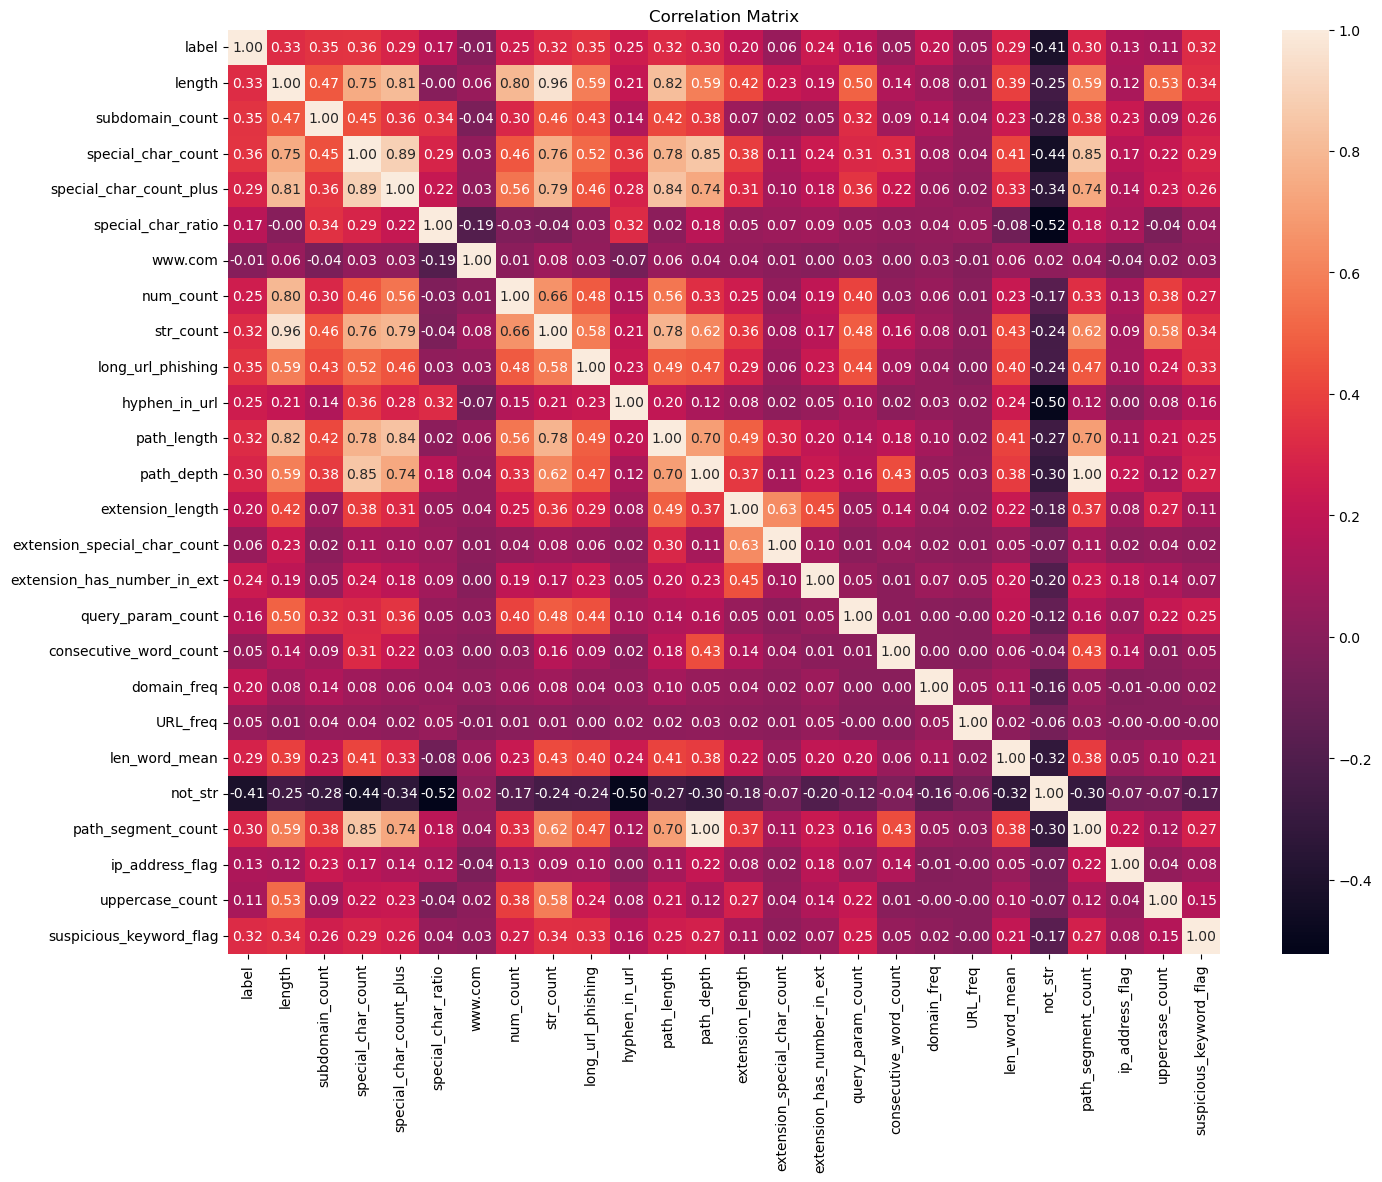

In [34]:
## 상관관계 분석
# 상관계수 계산
correlation_matrix = train_df[['label', 'length', 'subdomain_count', 'special_char_count',
       'special_char_count_plus', 'special_char_ratio', 'www.com', 'num_count',
       'str_count', 'long_url_phishing', 'hyphen_in_url', 'path_length',
       'path_depth', 'extension_length', 'extension_special_char_count',
       'extension_has_number_in_ext', 'query_param_count',
       'consecutive_word_count', 'domain_freq',
       'URL_freq', 'len_word_mean', 'not_str', 'path_segment_count',
       'ip_address_flag', 'uppercase_count', 'suspicious_keyword_flag']
].corr()

# 히트맵 시각화
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

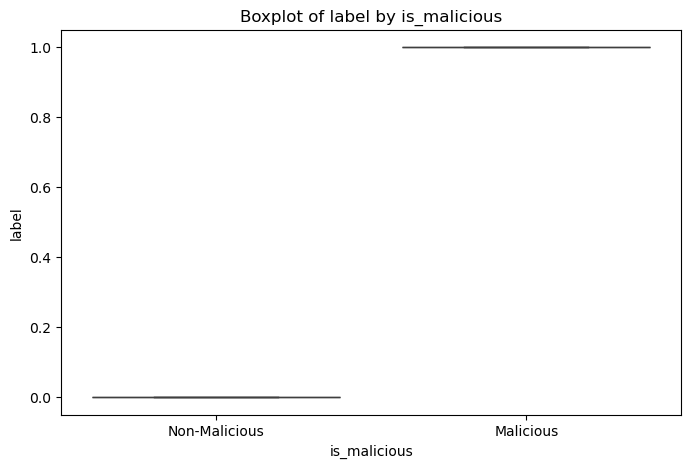

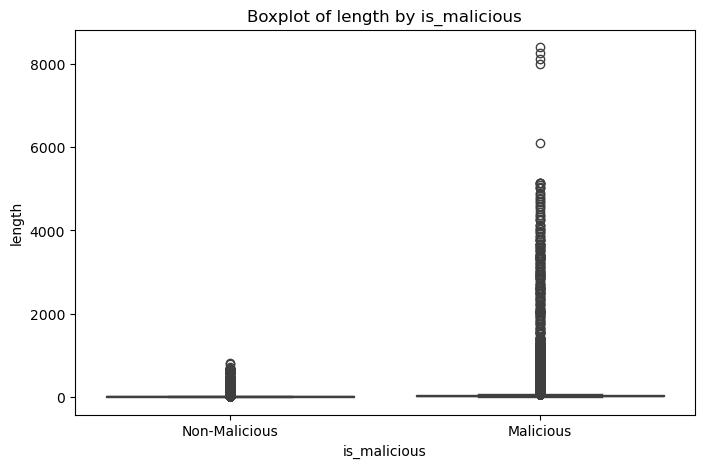

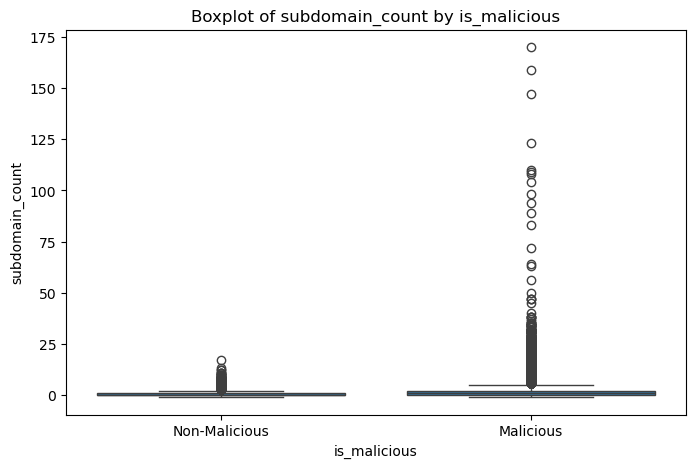

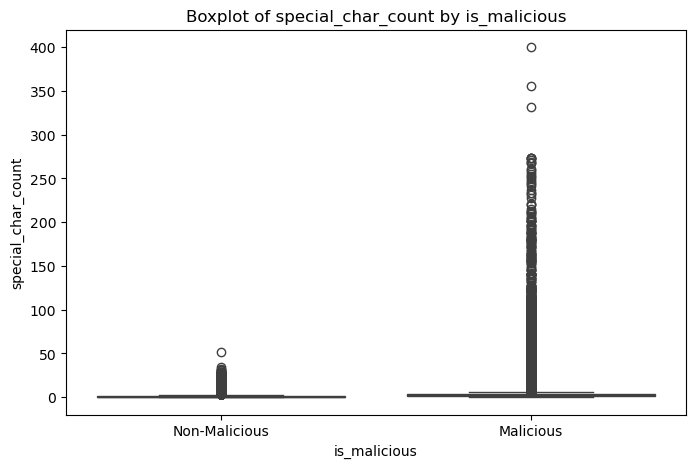

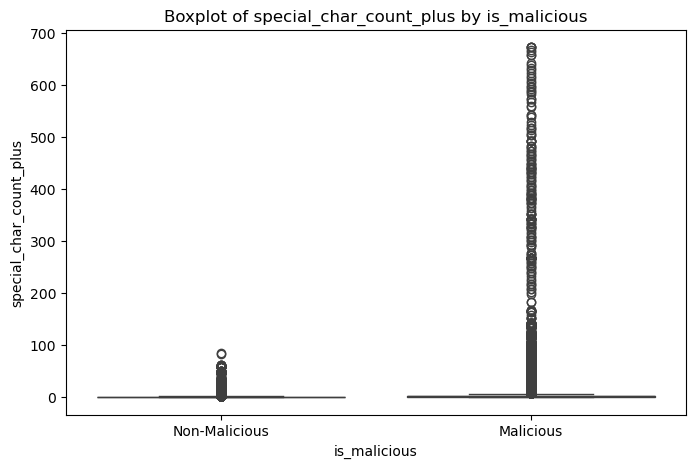

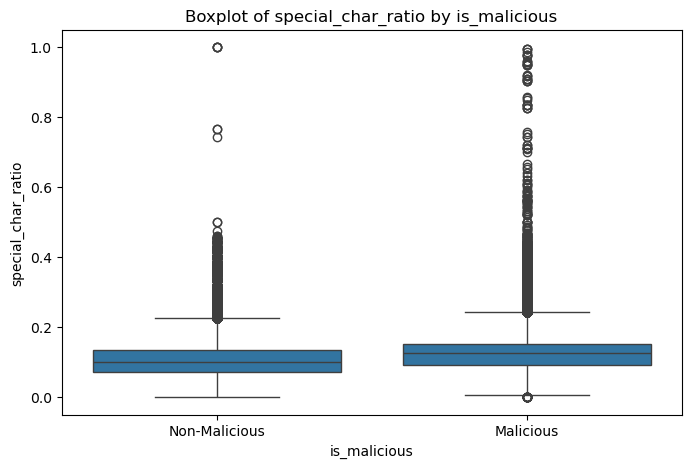

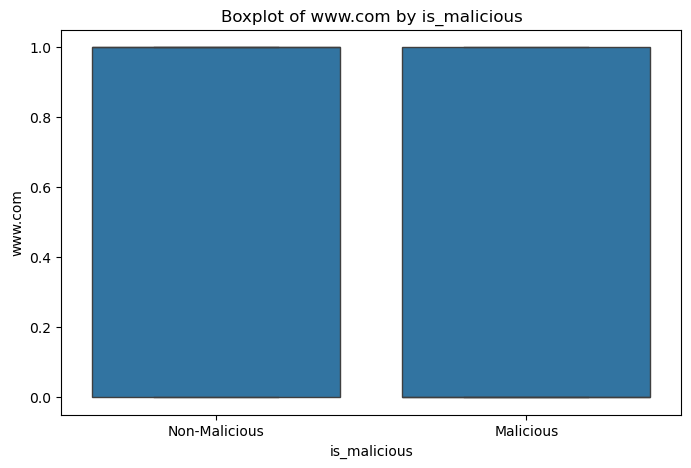

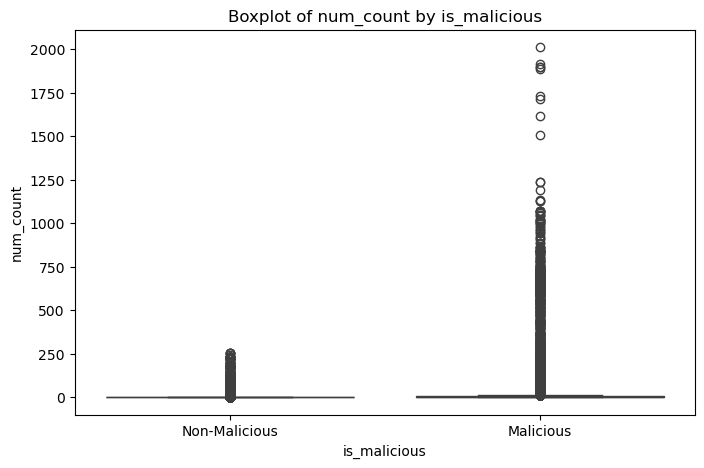

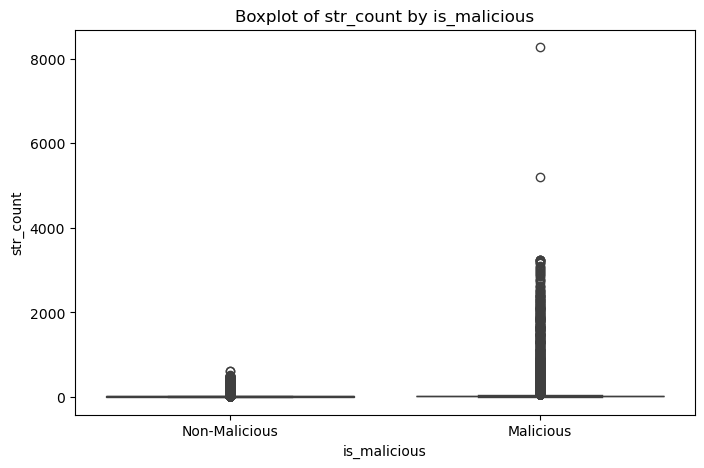

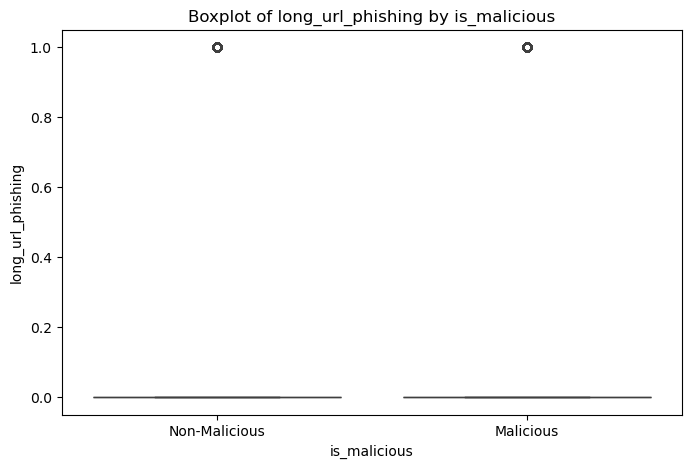

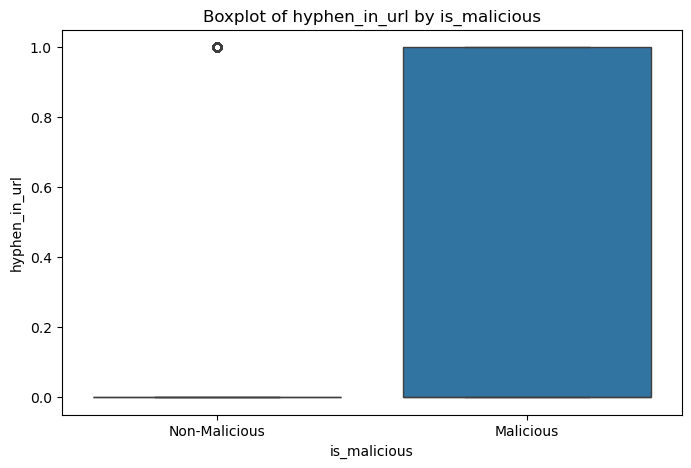

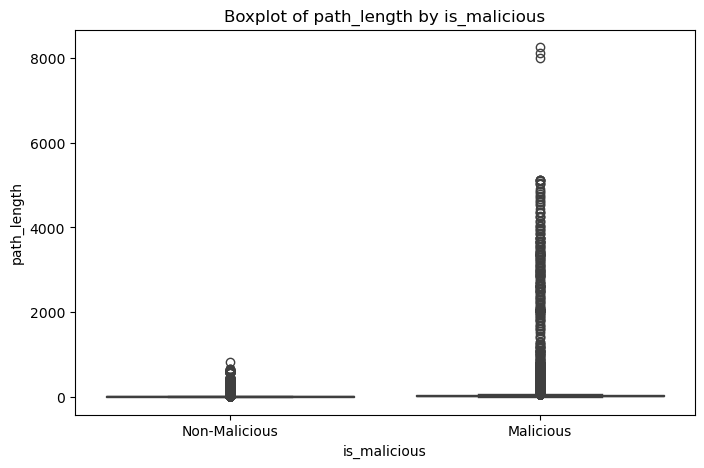

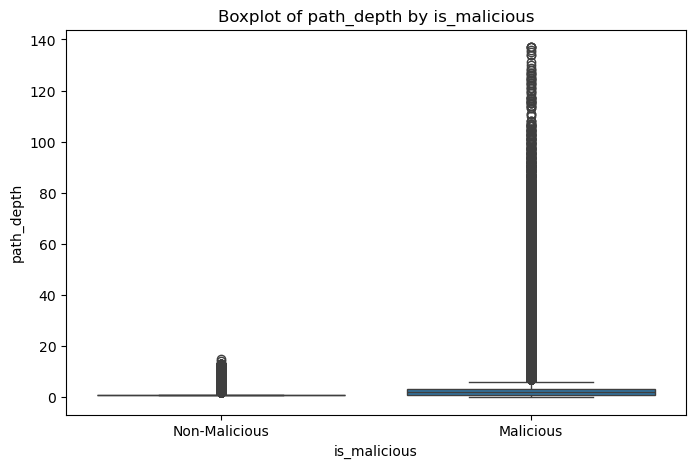

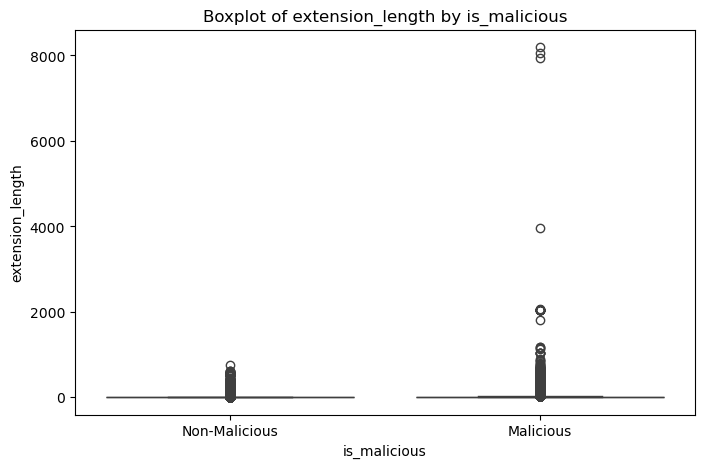

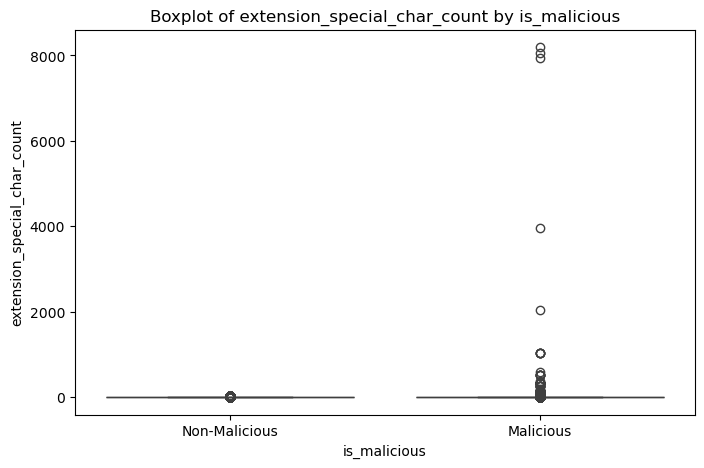

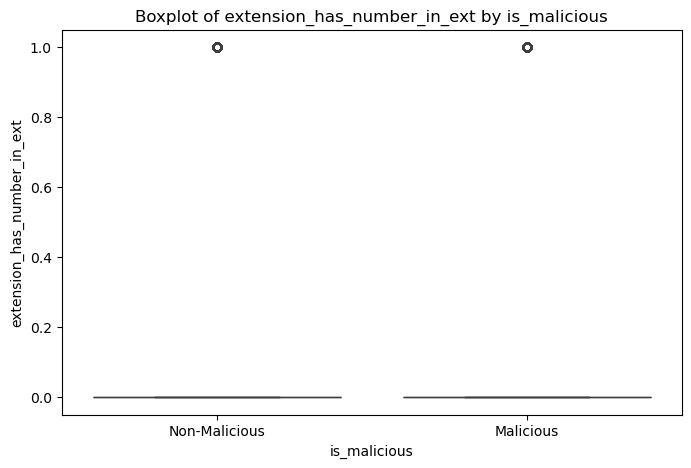

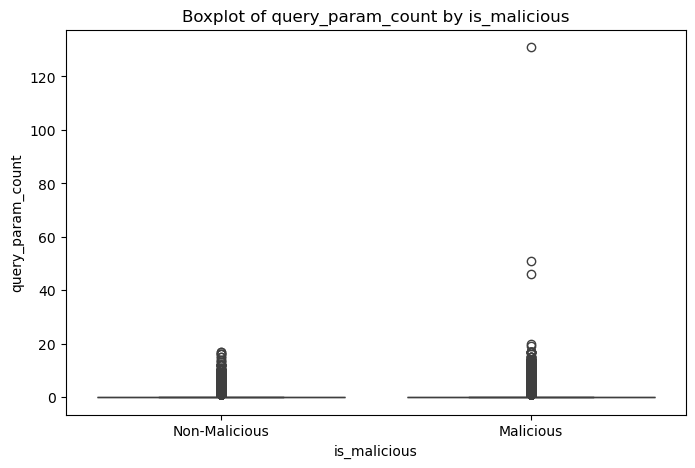

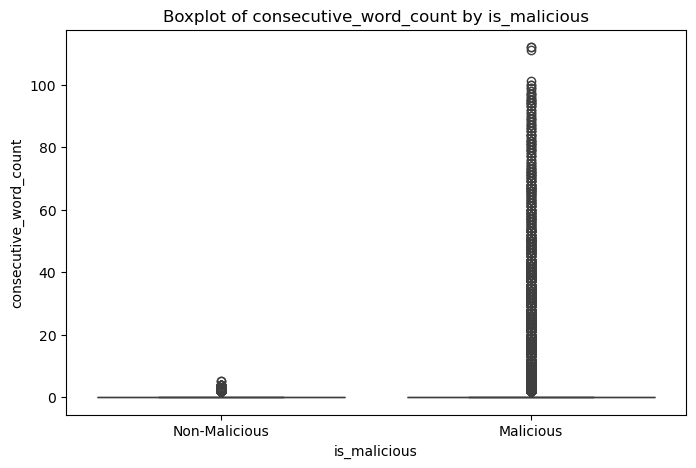

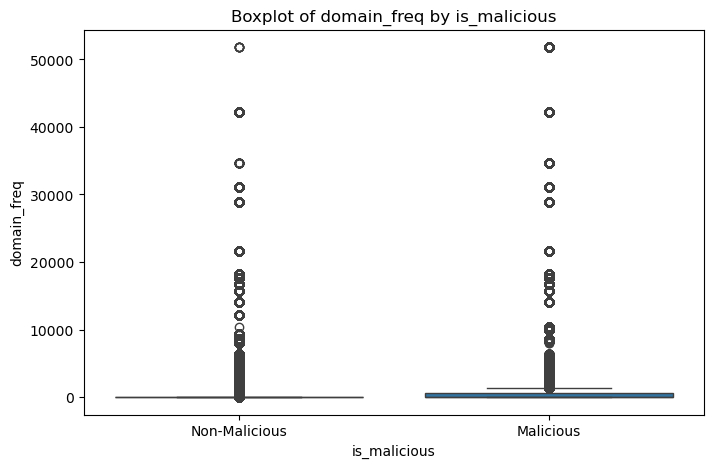

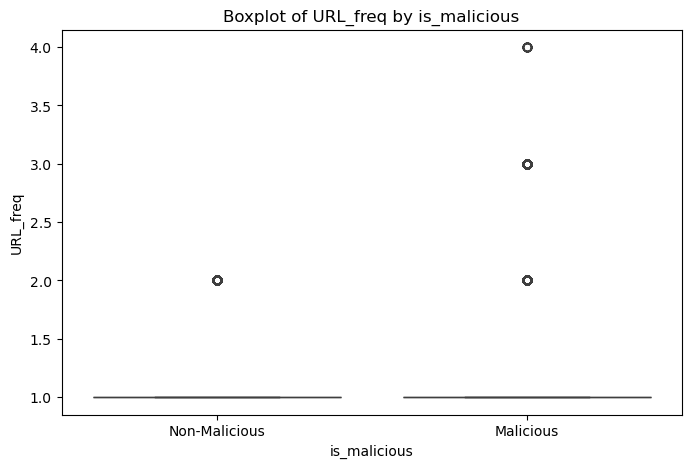

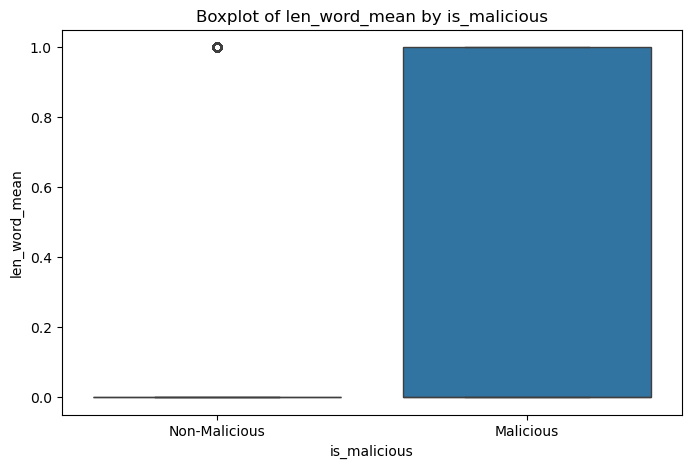

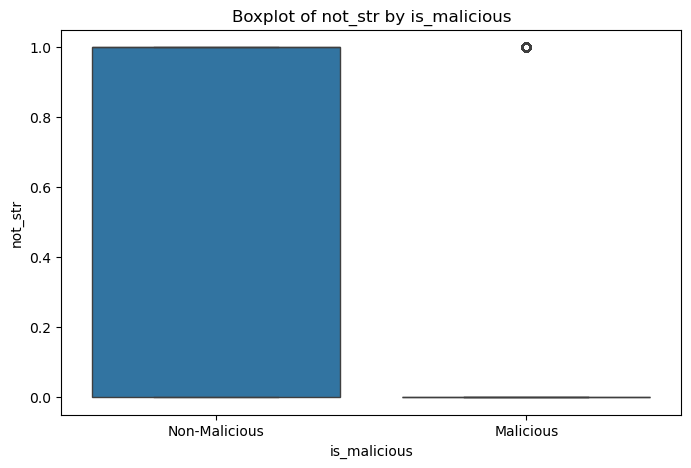

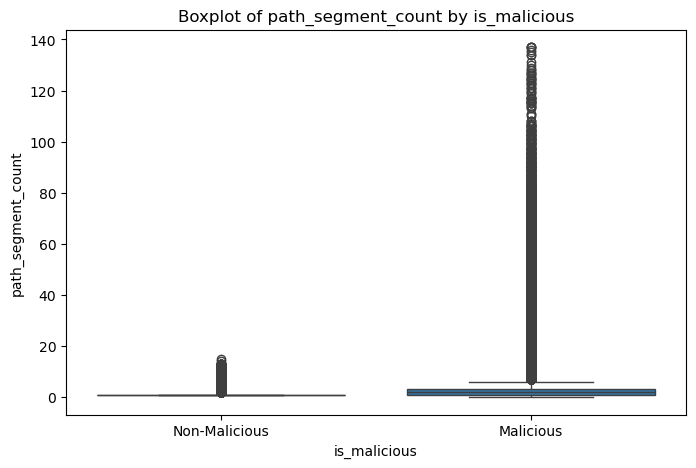

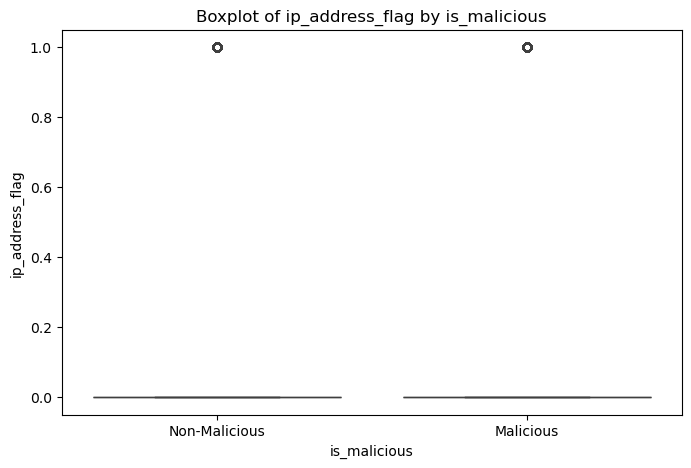

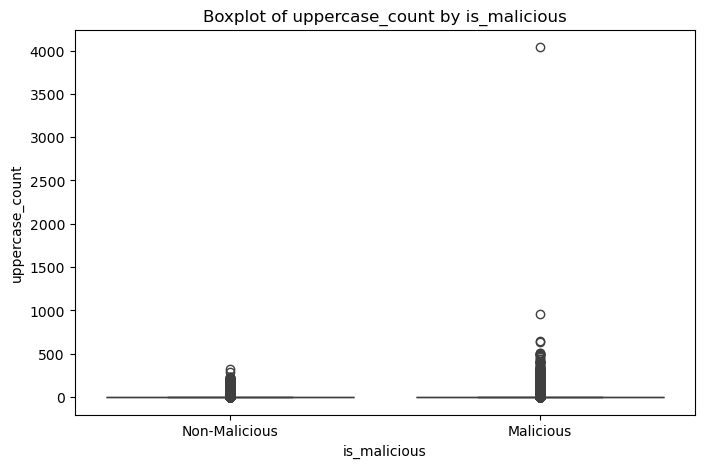

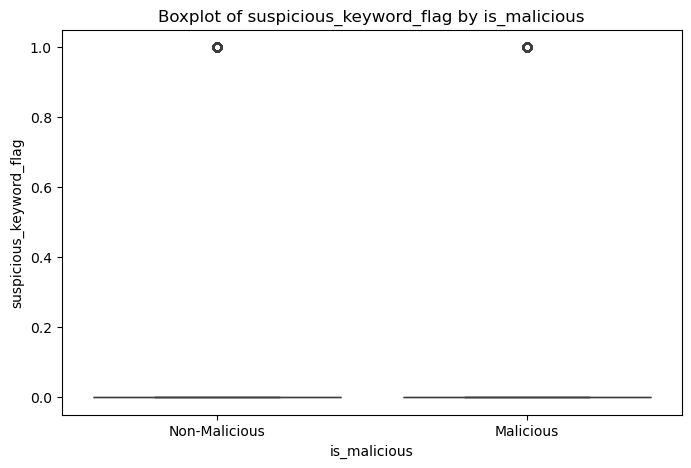

In [35]:
# 변수 목록
variables = ['label', 'length', 'subdomain_count', 'special_char_count',
       'special_char_count_plus', 'special_char_ratio', 'www.com', 'num_count',
       'str_count', 'long_url_phishing', 'hyphen_in_url', 'path_length',
       'path_depth', 'extension_length', 'extension_special_char_count',
       'extension_has_number_in_ext', 'query_param_count',
       'consecutive_word_count', 'domain_freq',
       'URL_freq', 'len_word_mean', 'not_str', 'path_segment_count',
       'ip_address_flag', 'uppercase_count', 'suspicious_keyword_flag']

# 박스플롯
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=var)
    plt.title(f"Boxplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

In [36]:
train_df.columns

Index(['ID', 'URL', 'label', 'length', 'subdomain_count', 'special_char_count',
       'special_char_count_plus', 'special_char_ratio', 'www.com', 'num_count',
       'str_count', 'long_url_phishing', 'hyphen_in_url', 'path_length',
       'path_depth', 'extension_length', 'extension_special_char_count',
       'extension_has_number_in_ext', 'query_param_count',
       'consecutive_word_count', 'tld', 'full_domain', 'domain_freq',
       'URL_freq', 'len_word_mean', 'not_str', 'path_segment_count',
       'ip_address_flag', 'uppercase_count', 'suspicious_keyword_flag'],
      dtype='object')

In [38]:
train_df.dtypes

ID                               object
URL                              object
label                             int64
length                            int64
subdomain_count                   int64
special_char_count                int64
special_char_count_plus           int64
special_char_ratio              float64
www.com                           int64
num_count                         int64
str_count                         int64
long_url_phishing                 int64
hyphen_in_url                     int64
path_length                       int64
path_depth                        int64
extension_length                  int64
extension_special_char_count      int64
extension_has_number_in_ext       int64
query_param_count                 int64
consecutive_word_count            int64
tld                              object
full_domain                      object
domain_freq                       int64
URL_freq                          int64
len_word_mean                     int64


In [254]:
# X값에 사용하는 컬럼
columns = ['length', 'subdomain_count', 'special_char_count',
       'special_char_count_plus', 'special_char_ratio', 'www.com', 'num_count',
       'str_count', 'long_url_phishing', 'hyphen_in_url', 'path_length',
       'path_depth', 'extension_length', 'extension_special_char_count',
       'extension_has_number_in_ext', 'query_param_count',
       'consecutive_word_count', 'domain_freq',
       'URL_freq', 'len_word_mean', 'not_str', 'path_segment_count',
       'ip_address_flag', 'uppercase_count', 'suspicious_keyword_flag']


# X, y 값 분배
X = train_df[columns]
y = train_df['label']

In [255]:
# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [256]:
from sklearn.model_selection import RandomizedSearchCV

In [205]:
param_dist = {
    'n_estimators': [230, 250, 280],         # 트리 개수 (많을수록 성능 증가, 속도 감소)
    'max_depth': [25, 30, 35],         # 트리 최대 깊이
    'min_samples_split': [8, 10, 13],      # 최소 분할 샘플 수
    'min_samples_leaf': [2, 3, 4]         # 리프 노드의 최소 샘플 수
}

In [206]:
rf_clf = RandomForestClassifier(
    n_estimators=2000,   # 트리 개수 2000개로 증가
    max_depth=50,        # 트리 깊이 증가
    max_samples=0.95,    # 95% 데이터 사용 (배깅 샘플링)
    bootstrap=True,      # 부트스트랩 방식 활성화
    oob_score=True,      # OOB 점수로 과적합 방지
    n_jobs=-1,           # 모든 코어 사용 (병렬 처리)
    random_state=42
)

In [207]:
# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    rf_clf, 
    param_distributions=param_dist, 
    n_iter=5,  # 10개의 조합만 랜덤으로 선택하여 탐색
    cv=2, 
    n_jobs=4, 
    verbose=2, 
    random_state=42
)

In [208]:
# 일부 데이터로 우선 실험
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.3, random_state=42)

In [209]:
# 하이퍼파라미터 최적화 진행
random_search.fit(X_sample, y_sample)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(max_depth=50,
                                                    max_samples=0.95,
                                                    n_estimators=2000,
                                                    n_jobs=-1, oob_score=True,
                                                    random_state=42),
                   n_iter=5, n_jobs=4,
                   param_distributions={'max_depth': [25, 30, 35],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [8, 10, 13],
                                        'n_estimators': [230, 250, 280]},
                   random_state=42, verbose=2)

In [210]:
# 최적 하이퍼파라미터 출력
print("최적 하이퍼파라미터:", random_search.best_params_)

최적 하이퍼파라미터: {'n_estimators': 230, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 30}


In [211]:
# 최적 모델로 전체 데이터 학습
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)# 최적 모델로 전체 데이터 학습

RandomForestClassifier(max_depth=30, max_samples=0.95, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=230, n_jobs=-1,
                       oob_score=True, random_state=42)

In [212]:
# 예측 및 평가 (테스트 데이터 필요)
y_pred = best_rf.predict(X_test)
print("최종 정확도:", accuracy_score(y_test, y_pred))

최종 정확도: 0.9395359010501697


In [ ]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
X = vectorizer.fit_transform(train_df['URL'])
y = np.array(train_df['label'])

In [355]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [356]:
from xgboost import XGBClassifier 

# XGBoost 모델 학습
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',tree_method='hist', max_bin=256)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [357]:
# 예측 및 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9429


In [358]:
X_test_new = vectorizer.transform(test_df['URL'])

In [359]:
# 확률 예측 수행
probabilities = model.predict_proba(X_test_new)[:,1] # 각 클래스 확률 예측

In [360]:
test_df['probability'] = probabilities

In [361]:
# 결과 저장
test_df[['ID', 'probability']].to_csv('submission_xgboost_0329_3.csv', index=False)
print('Done.')

Done.


In [81]:
# X값에 사용하는 컬럼
columns = ['length', 'subdomain_count', 'special_char_count',
       'special_char_count_plus', 'special_char_ratio', 'www.com', 'num_count',
       'str_count', 'long_url_phishing', 'hyphen_in_url', 'path_length',
       'path_depth', 'extension_length', 'extension_special_char_count',
       'extension_has_number_in_ext', 'query_param_count',
       'consecutive_word_count', 'domain_freq',
       'URL_freq', 'len_word_mean', 'not_str', 'path_segment_count',
       'ip_address_flag', 'uppercase_count', 'suspicious_keyword_flag']


# X, y 값 분배
nu_X = train_df[columns]
te_nu_X = test_df[columns]

In [82]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
X = vectorizer.fit_transform(train_df['URL'])

In [ ]:
te_X = vectorizer.transform(test_df['URL'])

In [103]:
nu_X = nu_X.astype('float64')
te_nu_X = te_nu_X.astype('float64')

X = X.astype('float64')
te_X = te_X.astype('float64')

In [104]:
# 최종 feature 결합 및 X값과 y값 설정
from scipy.sparse import hstack

X_final = hstack([X, nu_X])
y = train_df['label'].values

te_X_final = hstack([te_X, te_nu_X])


In [105]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [106]:
from xgboost import XGBClassifier 

# XGBoost 모델 학습
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',tree_method='hist', max_bin=256)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [107]:
# 예측 및 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9527


In [108]:
# 확률 예측 수행
probabilities = model.predict_proba(te_X_final)[:,1] # 각 클래스 확률 예측

In [109]:
test_df['probability'] = probabilities

In [110]:
# 결과 저장
test_df[['ID', 'probability']].to_csv('submission_xgboost_0329_5.csv', index=False)
print('Done.')

Done.


In [131]:
# X값에 사용하는 컬럼
columns = ['length', 'subdomain_count', 'special_char_count',
       'special_char_count_plus', 'special_char_ratio', 'www.com', 'num_count',
       'str_count', 'long_url_phishing', 'hyphen_in_url', 'path_length',
       'path_depth', 'extension_length', 'extension_special_char_count',
       'extension_has_number_in_ext', 'query_param_count',
       'consecutive_word_count', 'domain_freq',
       'len_word_mean', 'not_str',
    'uppercase_count', 'suspicious_keyword_flag']


# X, y 값 분배
nu_X = train_df[columns]
te_nu_X = test_df[columns]

In [132]:
nu_X = nu_X.astype('float64')
te_nu_X = te_nu_X.astype('float64')

X = X.astype('float64')
te_X = te_X.astype('float64')

In [133]:
# 최종 feature 결합 및 X값과 y값 설정
from scipy.sparse import hstack

X_final = hstack([X, nu_X])
y = train_df['label'].values

te_X_final = hstack([te_X, te_nu_X])


In [135]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [137]:
from xgboost import XGBClassifier 

# XGBoost 모델 학습
model = XGBClassifier(use_label_encoder=False, 
                      eval_metric='logloss',
                      tree_method='hist',
                      max_bin=256,
                     random_stat=50)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_stat=50, ...)

In [138]:
# 예측 및 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.7f}')

Accuracy: 0.9524128


In [ ]:
# 확률 예측 수행
probabilities = model.predict_proba(te_X_final)[:,1] # 각 클래스 확률 예측

In [ ]:
test_df['probability'] = probabilities

In [ ]:
# 결과 저장
test_df[['ID', 'probability']].to_csv('submission_xgboost_0330_1.csv', index=False)
print('Done.')

In [175]:
# X값에 사용하는 컬럼
columns = ['length', 'subdomain_count', 'special_char_count',
       'special_char_count_plus', 'special_char_ratio', 'www.com', 'num_count',
       'str_count', 'long_url_phishing', 'hyphen_in_url', 'path_length',
       'path_depth', 'extension_length', 'extension_special_char_count',
       'extension_has_number_in_ext', 'query_param_count',
       'consecutive_word_count', 'domain_freq',
       'URL_freq', 'len_word_mean', 'not_str', 'path_segment_count',
       'ip_address_flag', 'uppercase_count', 'suspicious_keyword_flag']


# X, y 값 분배
nu_X = train_df[columns]
te_nu_X = test_df[columns]

In [180]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
X = vectorizer.fit_transform(train_df['URL'])

In [181]:
te_X = vectorizer.transform(test_df['URL'])

In [ ]:
from urllib.parse import urlparse

train_df['domain'] = train_df['URL'].apply(lambda x: urlparse(x).netloc)  
train_df['path'] = train_df['URL'].apply(lambda x: urlparse(x).path)  
train_df['query'] = train_df['URL'].apply(lambda x: urlparse(x).query)

test_df['domain'] = test_df['URL'].apply(lambda x: urlparse(x).netloc)  
test_df['path'] = test_df['URL'].apply(lambda x: urlparse(x).path)  
test_df['query'] = test_df['URL'].apply(lambda x: urlparse(x).query)

In [ ]:
# 🔹 TF-IDF 벡터화 (도메인, 경로, 쿼리 각각 적용)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_domain = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
vectorizer_path = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))
vectorizer_query = TfidfVectorizer(analyzer='char', ngram_range=(1, 2))

In [ ]:
X_domain = vectorizer_domain.fit_transform(train_df['domain'])

In [ ]:
te_X_domain = vectorizer_domain.transform(test_df['domain'])

In [ ]:
X_path = vectorizer_path.fit_transform(train_df['path'])

In [ ]:
te_X_path = vectorizer_path.transform(test_df['path'])

In [ ]:
X_query = vectorizer_query.fit_transform(train_df['query'])

In [ ]:
te_X_query = vectorizer_query.transform(test_df['query'])

In [ ]:
nu_X = nu_X.astype('float64')
te_nu_X = te_nu_X.astype('float64')

X = X.astype('float64')
te_X = te_X.astype('float64')

X_domain = X_domain.astype('float64')
te_X_domain = te_X_domain.astype('float64')

X_path = X_path.astype('float64')
te_X_path = te_X_path.astype('float64')

X_query = X_query.astype('float64')
te_X_query = te_X_query.astype('float64')

In [206]:
# 최종 feature 결합 및 X값과 y값 설정
from scipy.sparse import hstack

X_final = hstack([X, nu_X, X_domain, X_path, X_query])
y = train_df['label'].values

te_X_final = hstack([te_X, te_nu_X, te_X_domain, te_X_path, te_X_query])


In [207]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [208]:
from xgboost import XGBClassifier 

# XGBoost 모델 학습
model = XGBClassifier(use_label_encoder=False, 
                      eval_metric='logloss',
                      tree_method='hist', 
                      max_bin=256,
                     random_status=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [213]:
# 예측 및 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9530


In [218]:
print(f'Accuracy: {accuracy:.7f}')

Accuracy: 0.9529547


In [220]:
# 확률 예측 수행
probabilities = model.predict_proba(te_X_final)[:,1] # 각 클래스 확률 예측

In [221]:
test_df['probability'] = probabilities

In [224]:
# 결과 저장
test_df[['ID', 'probability']].to_csv('submission_xgboost_0330_1.csv', index=False)
print('Done.')

Done.


## 특성 추가

In [ ]:
# 숫자 비율
train_df['digit_ratio'] = train_df['URL'].apply(lambda x: len(re.findall(r'\d', x)) / len(x))
test_df['digit_ratio'] = test_df['URL'].apply(lambda x: len(re.findall(r'\d', x)) / len(x))

# 알파벳 비율
train_df['alphabet_ratio'] = train_df['URL'].apply(lambda x: len(re.findall(r'[a-zA-Z]', x)) / len(x))
test_df['alphabet_ratio'] = test_df['URL'].apply(lambda x: len(re.findall(r'[a-zA-Z]', x)) / len(x))

# "https" 여부
train_df['https'] = train_df['URL'].apply(lambda x: 1 if "https" in x else 0)
test_df['https'] = test_df['URL'].apply(lambda x: 1 if "https" in x else 0)

# 쿼리 문자열 길이
train_df['query_string_length'] = train_df['URL'].apply(lambda x: len(re.findall(r'\?([^#]+)', x)))
test_df['query_string_length'] = test_df['URL'].apply(lambda x: len(re.findall(r'\?([^#]+)', x)))

In [270]:
train_df.columns

Index(['ID', 'URL', 'label', 'length', 'subdomain_count', 'special_char_count',
       'special_char_count_plus', 'special_char_ratio', 'www.com', 'num_count',
       'str_count', 'long_url_phishing', 'hyphen_in_url', 'path_length',
       'path_depth', 'extension_length', 'extension_special_char_count',
       'extension_has_number_in_ext', 'query_param_count',
       'consecutive_word_count', 'tld', 'full_domain', 'domain_freq',
       'URL_freq', 'len_word_mean', 'not_str', 'path_segment_count',
       'ip_address_flag', 'uppercase_count', 'suspicious_keyword_flag',
       'domain', 'path', 'query', 'digit_ratio', 'alphabet_ratio', 'https',
       'query_string_length'],
      dtype='object')

In [ ]:
# X값에 사용하는 컬럼
columns = ['length', 'subdomain_count', 'special_char_count',
       'special_char_count_plus', 'special_char_ratio', 'www.com', 'num_count',
       'str_count', 'long_url_phishing', 'hyphen_in_url', 'path_length',
       'path_depth', 'extension_length', 'extension_special_char_count',
       'extension_has_number_in_ext', 'query_param_count',
       'consecutive_word_count', 'domain_freq',
       'URL_freq', 'len_word_mean', 'not_str', 'path_segment_count',
       'ip_address_flag', 'uppercase_count', 'suspicious_keyword_flag',
          'digit_ratio', 'alphabet_ratio', 'https', 'query_string_length']


# X, y 값 분배
nu_X = train_df[columns]
te_nu_X = test_df[columns]

In [ ]:
nu_X = nu_X.astype('float64')
te_nu_X = te_nu_X.astype('float64')

X = X.astype('float64')
te_X = te_X.astype('float64')

X_domain = X_domain.astype('float64')
te_X_domain = te_X_domain.astype('float64')

X_path = X_path.astype('float64')
te_X_path = te_X_path.astype('float64')

X_query = X_query.astype('float64')
te_X_query = te_X_query.astype('float64')

In [ ]:
# 최종 feature 결합 및 X값과 y값 설정
from scipy.sparse import hstack

X_final = hstack([X, nu_X, X_domain, X_path, X_query])
y = train_df['label'].values

te_X_final = hstack([te_X, te_nu_X, te_X_domain, te_X_path, te_X_query])


In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [275]:
from xgboost import XGBClassifier 

# XGBoost 모델 학습
model = XGBClassifier(use_label_encoder=False, 
                      eval_metric='logloss',
                      tree_method='hist', 
                      max_bin=256)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [276]:
# 예측 및 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.7f}')

Accuracy: 0.9531262


In [277]:
# 확률 예측 수행
probabilities = model.predict_proba(te_X_final)[:,1] # 각 클래스 확률 예측

In [278]:
test_df['probability'] = probabilities

In [279]:
# 결과 저장
test_df[['ID', 'probability']].to_csv('submission_xgboost_0330_3.csv', index=False)
print('Done.')

Done.
